In [1]:
# import helper
import pandas as pd
from utils import *
import time
import numpy as np
import math
import pandas_ta  as ta
import datetime
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

## Brief Outline

In order to forecast the stock price, we need to collect data that would be useful in telling us whether the stock price might move up or down. These data give us key information that highlights different aspects of the stock. We use the following:

- Technical indicators
- Trend approximations (Fourier Transforms)
- ARIMA 
- Correlated assets


# Data Collection

In [3]:
sheet_1 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='Readme')
sheet_2 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='^FTSE')
sheet_3 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='GBP USD ')
sheet_4 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='Gold in USD')
sheet_5 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='Crude Futures')
sheet_6 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='GBP Libor')
sheet_7 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='UK Unemployment Historic')
sheet_8 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='UK CPI Data (MoM) ')
sheet_9 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='UK Retail Sales MoM')

In [4]:
all_sheets_name=['^FTSE','GBP USD ','Gold in USD','Crude Futures','GBP Libor','UK Unemployment Historic','UK CPI Data (MoM) ','UK Retail Sales MoM']
for i in range(len(all_sheets_name)):
    print('Sheet is  ',all_sheets_name[i])
    sheet_ = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name=all_sheets_name[i])
    print('Data contain heading',sheet_.columns)
    print('\n')

Sheet is   ^FTSE
Data contain heading Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Sheet is   GBP USD 
Data contain heading Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Sheet is   Gold in USD
Data contain heading Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Sheet is   Crude Futures
Data contain heading Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Sheet is   GBP Libor
Data contain heading Index(['Date', 'Week day', 'ON', '1W', '1M', '2M', '3M', '6M', '12M'], dtype='object')


Sheet is   UK Unemployment Historic
Data contain heading Index(['Release Date', 'Time', 'Actual', 'Forecast', 'Previous'], dtype='object')


Sheet is   UK CPI Data (MoM) 
Data contain heading Index(['Release Date', 'Time', 'Actual', 'Forecast', 'Previous'], dtype='object')


Sheet is   UK Retail Sales MoM
Data contain heading Index(['Release 

## Sheet2-Information

In [5]:
print("The start date is",sheet_2['Date'].values[0],"and the end date is",sheet_2['Date'].values[-1])
print("The start date is",sheet_3['Date'].values[0],"and the end date is",sheet_3['Date'].values[-1])
print("The start date is",sheet_4['Date'].values[0],"and the end date is",sheet_4['Date'].values[-1])
print("The start date is",sheet_5['Date'].values[0],"and the end date is",sheet_5['Date'].values[-1])

The start date is 2011-09-01 and the end date is 2023-09-12
The start date is 2011-09-01 and the end date is 2023-09-12
The start date is 2011-09-01 and the end date is 2023-09-12
The start date is 2011-09-01 and the end date is 2023-09-12


In [6]:
sheet_2

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-09-01,5394.5,5449.7,5346.7,5418.7,5418.7,975363800
1,2011-09-02,5418.7,5418.7,5258.5,5292.0,5292.0,823930000
2,2011-09-05,5292.0,5292.0,5097.7,5102.6,5102.6,788821300
3,2011-09-06,5102.6,5190.3,5086.8,5156.8,5156.8,946079100
4,2011-09-07,5156.8,5322.2,5156.8,5318.6,5318.6,837910500
...,...,...,...,...,...,...,...
3134,2023-09-06,7437.9,7447.9,7369.6,7426.1,7426.1,448751100
3135,2023-09-07,7426.1,7462.2,7385.9,7441.7,7441.7,456225400
3136,2023-09-08,7441.7,7480.6,7402.1,7478.2,7478.2,651366100
3137,2023-09-11,7478.2,7549.3,7467.4,7496.9,7496.9,568717300


In [7]:
import pandas
start='2011-09-01'
end='2023-09-12'
pandas.date_range(start,end,freq='B')
df_=pd.DataFrame(pandas.date_range(start,end,freq='B'),columns=['Date_'])

In [8]:
df_

,Date_
0,2011-09-01
1,2011-09-02
2,2011-09-05
3,2011-09-06
4,2011-09-07
...,...
3134,2023-09-06
3135,2023-09-07
3136,2023-09-08
3137,2023-09-11


In [9]:
print(sheet_2.columns)
print(" \nCount total NaN at each column in a DataFrame : \n\n", 
      sheet_2.isnull().sum()) 
print(sheet_2.info())
sheet_2['Date'] = pd.to_datetime(sheet_2['Date'], infer_datetime_format=True)
# sheet_2['Date'] = sheet_2['Date'].dt.date
print(sheet_2.info())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3139 non-null   object 
 1   Open       3139 non-null   float64
 2   High       3139 non-null   float64
 3   Low        3139 non-null   float64
 4   Close      3139 non-null   float64
 5   Adj Close  3139 non-null   float64
 6   Volume     3139 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 171.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Da

In [10]:
round(sheet_2[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(),2)
# Count total NaN at each column in a DataFrame 

,Open,High,Low,Close,Adj Close,Volume
Open,1.00,1.0,1.00,1.00,1.00,-0.11
High,1.00,1.0,1.00,1.00,1.00,-0.10
Low,1.00,1.0,1.00,1.00,1.00,-0.14
Close,1.00,1.0,1.00,1.00,1.00,-0.12
Adj Close,1.00,1.0,1.00,1.00,1.00,-0.12
Volume,-0.11,-0.1,-0.14,-0.12,-0.12,1.00


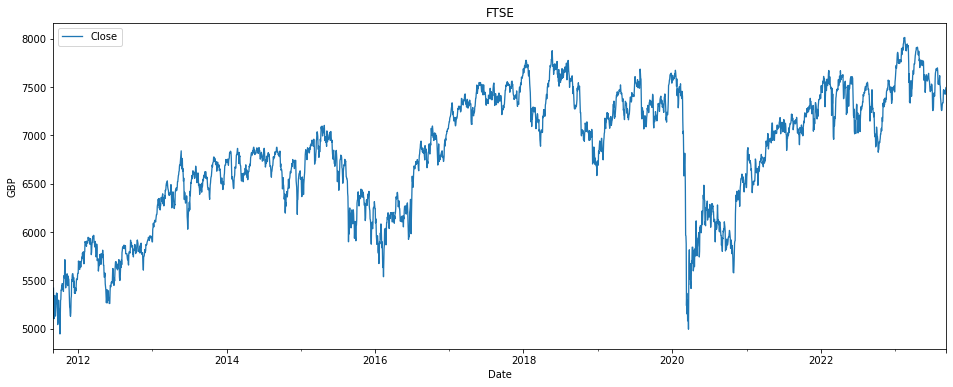

In [11]:
sheet_2.plot(y='Close',x='Date',figsize=(16, 6), linewidth=1.3)
plt.xlabel('Date')
plt.ylabel('GBP')
plt.title('FTSE')
plt.legend()
plt.show()

In [12]:
print(sheet_3.columns)
print(" \nCount total NaN at each column in a DataFrame : \n\n", 
      sheet_3.isnull().sum()) 
print(sheet_3.info())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3139 non-null   object 
 1   Open       3139 non-null   float64
 2   High       3139 non-null   float64
 3   Low        3139 non-null   float64
 4   Close      3139 non-null   float64
 5   Adj Close  3139 non-null   float64
 6   Volume     3139 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 171.8+ KB
None


In [13]:
round(sheet_3[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(),2)
# Count total NaN at each column in a DataFrame 

,Open,High,Low,Close,Adj Close,Volume
Open,1.00,1.00,0.99,1.00,1.00,NaN
High,1.00,1.00,0.99,1.00,1.00,NaN
Low,0.99,0.99,1.00,0.99,0.99,NaN
Close,1.00,1.00,0.99,1.00,1.00,NaN
Adj Close,1.00,1.00,0.99,1.00,1.00,NaN
Volume,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
print(sheet_4.columns)
print(" \nCount total NaN at each column in a DataFrame : \n\n", 
      sheet_4.isnull().sum()) 
print(sheet_4.info())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3139 non-null   object 
 1   Open       3139 non-null   float64
 2   High       3139 non-null   float64
 3   Low        3139 non-null   float64
 4   Close      3139 non-null   float64
 5   Adj Close  3139 non-null   float64
 6   Volume     3139 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 171.8+ KB
None


In [15]:
round(sheet_4[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(),2)
# Count total NaN at each column in a DataFrame 

,Open,High,Low,Close,Adj Close,Volume
Open,1.00,1.00,1.00,1.00,1.00,-0.02
High,1.00,1.00,1.00,1.00,1.00,-0.02
Low,1.00,1.00,1.00,1.00,1.00,-0.02
Close,1.00,1.00,1.00,1.00,1.00,-0.02
Adj Close,1.00,1.00,1.00,1.00,1.00,-0.02
Volume,-0.02,-0.02,-0.02,-0.02,-0.02,1.00


In [16]:
print(sheet_5.columns)
print(" \nCount total NaN at each column in a DataFrame : \n\n", 
      sheet_5.isnull().sum()) 
print(sheet_5.info())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3139 non-null   object 
 1   Open       3139 non-null   float64
 2   High       3139 non-null   float64
 3   Low        3139 non-null   float64
 4   Close      3139 non-null   float64
 5   Adj Close  3139 non-null   float64
 6   Volume     3139 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 171.8+ KB
None


In [17]:
round(sheet_5[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(),2)
# Count total NaN at each column in a DataFrame 

,Open,High,Low,Close,Adj Close,Volume
Open,1.0,1.00,1.0,1.0,1.0,-0.60
High,1.0,1.00,1.0,1.0,1.0,-0.59
Low,1.0,1.00,1.0,1.0,1.0,-0.60
Close,1.0,1.00,1.0,1.0,1.0,-0.60
Adj Close,1.0,1.00,1.0,1.0,1.0,-0.60
Volume,-0.6,-0.59,-0.6,-0.6,-0.6,1.00


## Technical Indicators

Many investors use technical indicators of a stock to decide whether to invest or not. Thus, we use various technical indicators as independent variables for our model. The list includes:

- Moving averages (SMA) : When price action tends to stay above the moving average, it signals that price is in a general UPTREND. If price action tends to stay below the moving average, then it indicates that it is in a DOWNTREND. In an uptrend, the “faster” moving average should be above the “slower” moving average, and for a downtrend, vice versa. The input is window size of moving average.
- Moving averages convergence divergences (MACD)

Fast Line: The "fast" component of the MACD refers to the 12-period Exponential Moving Average (EMA). This EMA is faster because it considers a shorter time frame compared to the "slow" component.

Slow Line: The "slow" component of the MACD refers to the 26-period Exponential Moving Average (EMA). It's called "slow" because it takes into account a longer time frame compared to the "fast" line.

Signal Line: The "signal" line is derived from the MACD line itself. It's often a 9-period Exponential Moving Average of the MACD line. This signal line helps traders identify potential crossovers and confirm trends indicated by the MACD line.

The MACD line is the difference between the fast and slow EMAs (MACD = 12-period EMA - 26-period EMA).

The Signal line is a 9-period EMA of the MACD line.

Crossovers between the MACD line and the Signal line are often used as buy or sell signals in technical analysis. For example, when the MACD line crosses above the Signal line, it might be considered a bullish signal, indicating a potential uptrend, and vice versa.
- Bollinger bands

In ta (technical analysis) library within Pandas, the Bollinger Bands indicator can be calculated using the BollingerBands class. Bollinger Bands are volatility bands placed above and below a moving average. They are based on standard deviations of price movements

'close' represents the column in your DataFrame that contains the closing prices.

'window' is the period for the moving average used to calculate the middle Bollinger Band.

'window_dev' represents the number of standard deviations to be used for the upper and lower bands.

Window (Period): This parameter determines the number of periods used in the moving average calculation for the middle Bollinger Band. Common values for the window can range from 20 to 50 periods, but it's often adapted to the timeframe you're working with. For daily data, a window of 20 periods is quite common, but for shorter timeframes like intraday data, you might consider shorter windows (e.g., 10 or 14 periods) to capture more recent price movements.

Window Deviations: This parameter sets the number of standard deviations from the moving average used to calculate the upper and lower bands. Commonly, two standard deviations are used (window_dev = 2), but this can be adjusted depending on the level of volatility in the market. Higher deviations widen the bands, which might capture more price movements but can potentially result in fewer signals.

- Exponential moving average (EMA). The input is window size of Exponential moving average.

The following code gets the technical indicators and plots their information

In [18]:
import copy
df = copy.deepcopy(sheet_2)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-09-01,5394.5,5449.7,5346.7,5418.7,5418.7,975363800
1,2011-09-02,5418.7,5418.7,5258.5,5292.0,5292.0,823930000
2,2011-09-05,5292.0,5292.0,5097.7,5102.6,5102.6,788821300
3,2011-09-06,5102.6,5190.3,5086.8,5156.8,5156.8,946079100
4,2011-09-07,5156.8,5322.2,5156.8,5318.6,5318.6,837910500


In [19]:
help(ta.sma)

Help on function sma in module pandas_ta.overlap.sma:

sma(close, length=None, talib=None, offset=None, **kwargs)
    Simple Moving Average (SMA)
    
    The Simple Moving Average is the classic moving average that is the equally
    weighted average over n periods.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/simple-moving-average-sma/
    
    Calculation:
        Default Inputs:
            length=10
        SMA = SUM(close, length) / length
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 10
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        adjust (bool): Default: True
        presma (bool, optional): If True, uses SMA for initial value.
        fillna (value, optional): pd.DataFrame.fillna(value)
     

In [20]:
price_size = (16, 8)
ind_size = (16, 2)
recent = 300
half_of_recent = int(0.5 * recent)
last_ = df.shape[0]
recent_startdate = df.tail(2)['Date'].values[0]
recent_enddate = df.tail(2)['Date'].values[-1]
print(f"{df.shape} from {recent_startdate} to {recent_enddate}\n{df.describe()}")

(3139, 7) from 2023-09-11T00:00:00.000000000 to 2023-09-12T00:00:00.000000000
              Open         High          Low        Close    Adj Close  \
count  3139.000000  3139.000000  3139.000000  3139.000000  3139.000000   
mean   6793.606371  6833.296305  6753.535680  6794.431857  6794.431857   
std     649.958685   644.608521   655.918874   649.676189   649.676189   
min    4944.400000  5075.500000  4868.600000  4944.400000  4944.400000   
25%    6338.800000  6380.500000  6297.450000  6339.050000  6339.050000   
50%    6855.100000  6884.600000  6819.300000  6855.800000  6855.800000   
75%    7337.900000  7377.400000  7302.700000  7337.900000  7337.900000   
max    8014.300000  8047.100000  7995.500000  8014.300000  8014.300000   

             Volume  
count  3.139000e+03  
mean   7.813391e+08  
std    2.657267e+08  
min    8.378200e+06  
25%    6.323042e+08  
50%    7.458386e+08  
75%    8.748451e+08  
max    3.761301e+09  


In [21]:
ticker='FTSE'
def ctitle(indicator_name, ticker, length=100):
    return f"{ticker}: {indicator_name} from {recent_startdate} to {recent_startdate} ({length})"

In [22]:
opendf = df['Open']
closedf = df['Close']
volumedf = df['Volume']
datedf=df['Date']

In [23]:
def cscheme(colors):
    aliases = {
        'BkBu': ['black', 'blue'],
        'gr': ['green', 'red'],
        'grays': ['silver', 'gray'],
        'mas': ['black', 'green', 'orange', 'red'],
    }
    aliases['default'] = aliases['gr']
    return aliases[colors]

def machart(kind, fast, medium, slow, append=True, last=last_, figsize=price_size, colors=cscheme('mas')):
    title = ctitle(f"{kind.upper()}s", ticker=ticker, length=last)
    ma1 = df.ta(kind=kind, length=fast, append=append,fillna=0)
    ma2 = df.ta(kind=kind, length=medium, append=append,fillna=0)
    ma3 = df.ta(kind=kind, length=slow, append=append,fillna=0)
    
    madf = pd.concat([datedf,closedf, df[[ma1.name, ma2.name, ma3.name]]], axis=1, sort=False).tail(last)
    madf.plot(x='Date',figsize=figsize, title=title, color=colors, grid=True) 
#     madf.set_index(['date'], inplace=True)

def volumechart(kind, length=10, last=last_, figsize=ind_size, alpha=0.7, colors=cscheme('gr')):
    title = ctitle("Volume", ticker=ticker, length=last)
    volume = pd.DataFrame({'V+': volumedf[closedf > opendf], 'V-': volumedf[closedf < opendf]}).tail(last)
    
    volume.plot(kind='bar', figsize=figsize, width=0.5, color=colors, alpha=alpha, stacked=True)
    vadf = df.ta(kind=kind, close=volumedf, length=length).tail(last)
    vadf.plot(figsize=figsize, lw=1.4, color='black', title=title, rot=45, grid=True)

In [24]:
# machart('ema', 8, 21, 50, last=recent)
# volumechart('ema', last=recent)

# matype = 'sma'
# fast_length = 10
# medfast_length = 20
# slow_length = 50
# machart(matype, fast_length, medfast_length, slow_length, last=half_of_recent)

In [25]:
def TechInd(df):
    # Exponential moving average (EMA)
    machart('ema', 10, 20, 50, last=recent)
    # Simple Moving Average (SMA)
    matype = 'sma'
    fast_length = 10
    medfast_length = 20
    slow_length = 50
    machart(matype, fast_length, medfast_length, slow_length, last=half_of_recent)
    # Cumulative Log Return
    clr_ma_length = 8
    clrdf = df.ta.log_return(cumulative=True, append=True,fillna=0)
    clrmadf = ta.ema(clrdf, length=clr_ma_length)
    qqdf = pd.DataFrame({f"{clrdf.name}": clrdf, f"{clrmadf.name}({clrdf.name})": clrmadf})
    qqdf_ = pd.concat([datedf, qqdf], axis=1, sort=False).tail(recent)
    qqdf_.plot(x='Date',figsize=ind_size, color=cscheme('BkBu'), linewidth=1, title=ctitle(clrdf.name, ticker=ticker, length=recent), grid=True)
    # MACD
    macddf = df.ta.macd(fast=12, slow=26, signal=9, min_periods=None, append=True,fillna=0)
    df['MACDs_12_26_9']=df['MACDs_12_26_9'].fillna(value=0)
    macddf_ = pd.concat([datedf, macddf[[macddf.columns[0], macddf.columns[2]]]], axis=1, sort=False).tail(recent)
    macddf_.plot(x='Date',figsize=(16, 2), color=cscheme('BkBu'), linewidth=1.3)
    # Bollinger bands
    bbandsdf=df.ta.bbands(close='Close', length=20, std=2, append=True,fillna=0)
    bbandsdf_ = pd.concat([datedf,closedf,bbandsdf[[bbandsdf.columns[0], bbandsdf.columns[1],bbandsdf.columns[2]]]], axis=1, sort=False).tail(recent)
    bbandsdf_.plot(x='Date',figsize=(16, 2), color=cscheme('BkBu'), linewidth=1.3)
    return df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_20,EMA_50,...,SMA_50,CUMLOGRET_1,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
0,2011-09-01,5394.5,5449.7,5346.7,5418.7,5418.7,975363800,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-09-02,5418.7,5418.7,5258.5,5292.0,5292.0,823930000,0.0,0.0,0.0,...,0.0,-0.023660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-09-05,5292.0,5292.0,5097.7,5102.6,5102.6,788821300,0.0,0.0,0.0,...,0.0,-0.060106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-09-06,5102.6,5190.3,5086.8,5156.8,5156.8,946079100,0.0,0.0,0.0,...,0.0,-0.049540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-09-07,5156.8,5322.2,5156.8,5318.6,5318.6,837910500,0.0,0.0,0.0,...,0.0,-0.018646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


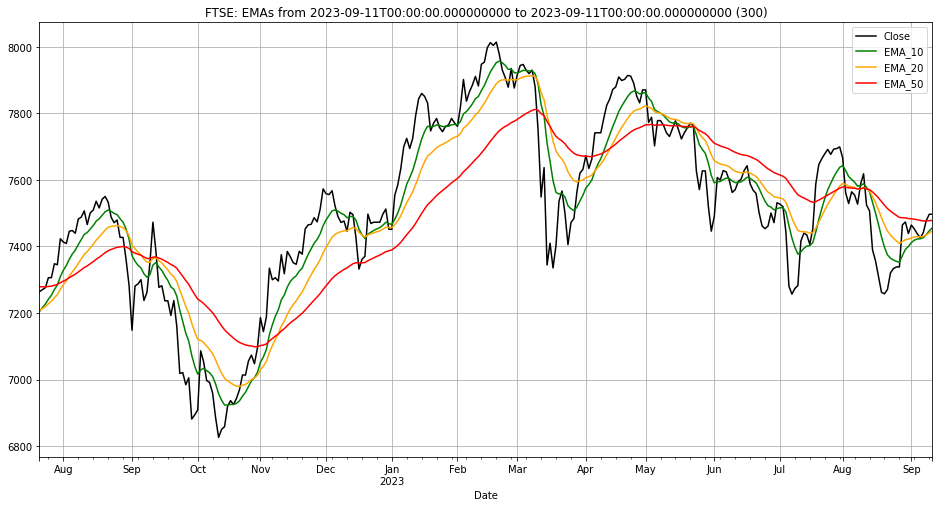

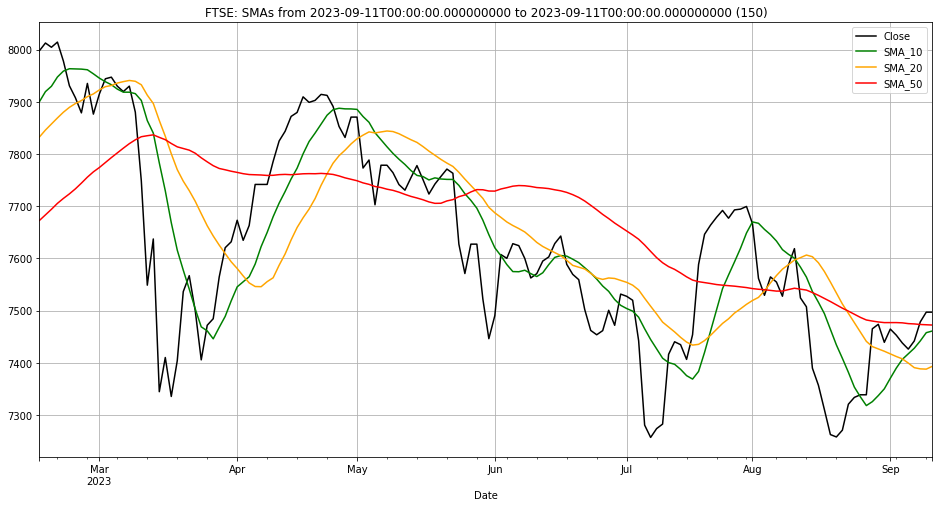

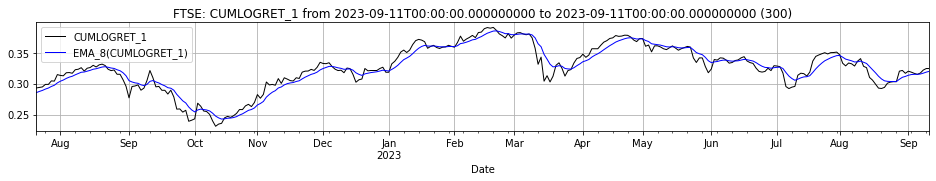

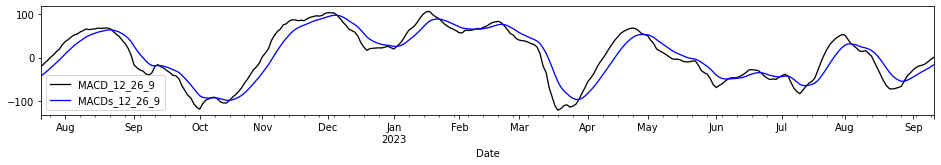

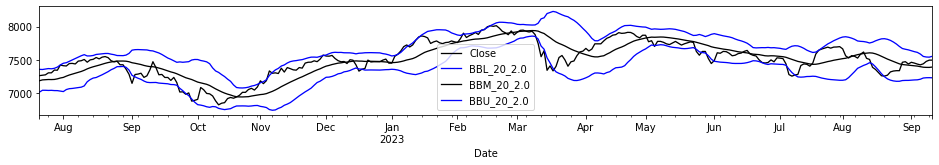

In [26]:
TechInd(df).head()

## Trend Approximations (Fourier Transforms)

Performing Fourier transforms of the stock prices allow to get trend approximations of the stock by reducing the noise and a lot of the random walk, thus getting a general idea of long term and short term trends of the stock. <br>

The following code performs the Fourier transforms with 3, 6 and 9 components, and plots the data.

In [27]:
data_FT = df[['Date', 'Close']]

In [28]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

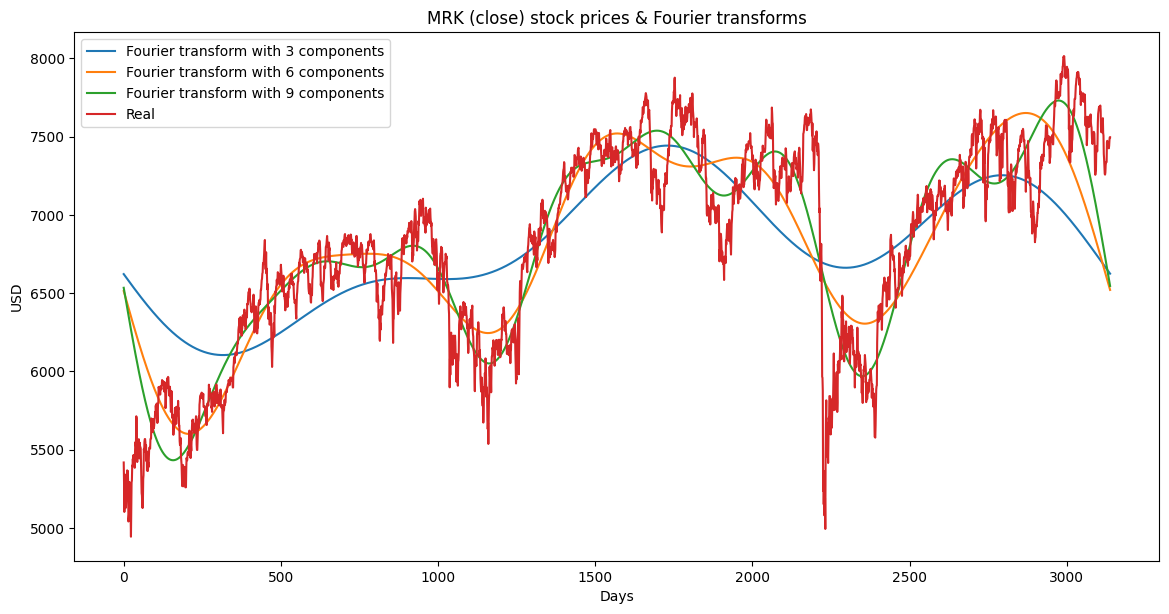

In [29]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('MRK (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

## ARIMA

Prior to neural networks and even today, many companies use ARIMA as a model to predict time series data. Hence, we use it as an independent variable, as it might contain patterns essential to the prediction.

In [30]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
#model_fit = model.fit(disp=0)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3139
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -17463.672
Date:                Thu, 11 Jan 2024   AIC                          34939.343
Time:                        09:51:39   BIC                          34975.651
Sample:                             0   HQIC                         34952.373
                               - 3139                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0015      0.012     -0.125      0.901      -0.025       0.022
ar.L2         -0.0176      0.013     -1.394      0.163      -0.042       0.007
ar.L3         -0.0101      0.010     -1.056      0.2

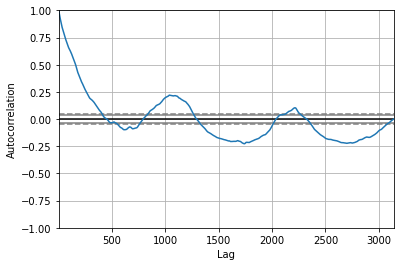

<Figure size 800x560 with 0 Axes>

In [31]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [32]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    #model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [33]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 5836.103


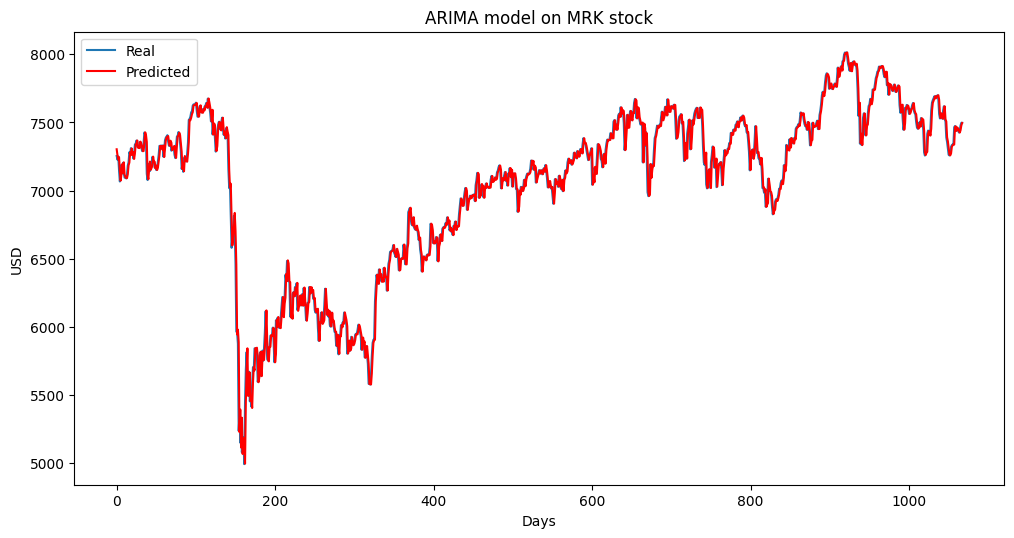

In [34]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARIMA model on MRK stock')
plt.legend()
plt.show()

## Trend Approximations

We perform the Fourier transforms with 3,6 and 9 components and add it to the dataset

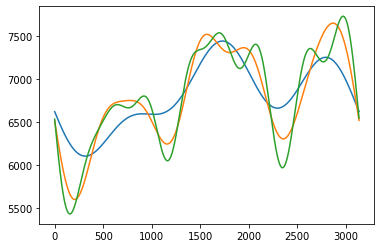

In [35]:
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))

In [36]:
fft_list_3 = np.copy(fft_list); fft_list_3[3:-3]=0
df['FT3'] = np.fft.ifft(fft_list_3).real

In [37]:
fft_list_6 = np.copy(fft_list); fft_list_6[6:-6]=0
df['FT6'] = np.fft.ifft(fft_list_6).real

In [38]:
fft_list_9 = np.copy(fft_list); fft_list_9[9:-9]=0
df['FT9'] = np.fft.ifft(fft_list_9).real

In [39]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_20,EMA_50,...,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FT3,FT6,FT9
0,2011-09-01,5394.5,5449.7,5346.7,5418.7,5418.7,975363800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6622.292698,6514.015038,6534.857839
1,2011-09-02,5418.7,5418.7,5258.5,5292.0,5292.0,823930000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6619.516369,6506.886603,6523.108748
2,2011-09-05,5292.0,5292.0,5097.7,5102.6,5102.6,788821300,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6616.741799,6499.760942,6511.366617
3,2011-09-06,5102.6,5190.3,5086.8,5156.8,5156.8,946079100,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6613.969056,6492.638445,6499.632794
4,2011-09-07,5156.8,5322.2,5156.8,5318.6,5318.6,837910500,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6611.198208,6485.519505,6487.908627


## ARIMA 

We put the true data for the training values, and the predictions for the test values.

In [40]:
training_predictions = np.concatenate((train, np.array(predictions)))

In [41]:
df['ARIMA'] = training_predictions

In [42]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_20,EMA_50,...,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FT3,FT6,FT9,ARIMA
0,2011-09-01,5394.5,5449.7,5346.7,5418.7,5418.7,975363800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6622.292698,6514.015038,6534.857839,5418.7
1,2011-09-02,5418.7,5418.7,5258.5,5292.0,5292.0,823930000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6619.516369,6506.886603,6523.108748,5292.0
2,2011-09-05,5292.0,5292.0,5097.7,5102.6,5102.6,788821300,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6616.741799,6499.760942,6511.366617,5102.6
3,2011-09-06,5102.6,5190.3,5086.8,5156.8,5156.8,946079100,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6613.969056,6492.638445,6499.632794,5156.8
4,2011-09-07,5156.8,5322.2,5156.8,5318.6,5318.6,837910500,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6611.198208,6485.519505,6487.908627,5318.6


##  Correlated Assets

In [43]:
df['GBP USD '] = list(sheet_3['Close'])
df['Gold in USD'] = list(sheet_4['Close'])
df['Crude Futures'] = list(sheet_5['Close'])

In [44]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'EMA_10',
       'EMA_20', 'EMA_50', 'SMA_10', 'SMA_20', 'SMA_50', 'CUMLOGRET_1',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0',
       'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'FT3', 'FT6',
       'FT9', 'ARIMA', 'GBP USD ', 'Gold in USD', 'Crude Futures'],
      dtype='object')

In [62]:
dataset_total_df = df[list(df.columns.difference(['Open', 'High', 'Low','Date']))]

In [63]:
is_NaN = dataset_total_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
dataset_total_df_clean = dataset_total_df[-row_has_NaN]

In [64]:
dataset_total_df_clean

,ARIMA,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,...,FT9,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume
0,5418.700000,5418.7,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,5418.7,114.29,...,6534.857839,1.63,1826.0,0.000000,0.000000,0.000000,0.00,0.000,0.000,975363800
1,5292.000000,5292.0,0.000000,0.000000,0.000,0.000000,0.000000,-0.023660,5292.0,112.33,...,6523.108748,1.62,1873.7,0.000000,0.000000,0.000000,0.00,0.000,0.000,823930000
2,5102.600000,5102.6,0.000000,0.000000,0.000,0.000000,0.000000,-0.060106,5102.6,112.33,...,6511.366617,1.62,1873.7,0.000000,0.000000,0.000000,0.00,0.000,0.000,788821300
3,5156.800000,5156.8,0.000000,0.000000,0.000,0.000000,0.000000,-0.049540,5156.8,112.89,...,6499.632794,1.61,1869.9,0.000000,0.000000,0.000000,0.00,0.000,0.000,946079100
4,5318.600000,5318.6,0.000000,0.000000,0.000,0.000000,0.000000,-0.018646,5318.6,115.80,...,6487.908627,1.59,1814.2,0.000000,0.000000,0.000000,0.00,0.000,0.000,837910500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,7438.647519,7426.1,5.115504,7210.146579,7399.405,0.570525,7588.663421,0.315145,7426.1,90.60,...,6593.660422,1.26,1918.1,-17.311680,14.831437,-32.143118,7416.99,7399.405,7474.952,448751100
3135,7425.646055,7441.7,4.384831,7228.528220,7390.560,0.657809,7552.591780,0.317243,7441.7,89.92,...,6581.896796,1.25,1917.5,-14.436416,14.165362,-28.601777,7427.80,7390.560,7474.352,456225400
3136,7442.519622,7478.2,4.210870,7232.704989,7388.260,0.789094,7543.815011,0.322136,7478.2,90.65,...,6570.133371,1.25,1918.4,-9.107517,15.595408,-24.702925,7441.76,7388.260,7473.286,651366100
3137,7478.162860,7496.9,4.170076,7233.707713,7387.745,0.854314,7541.782287,0.324634,7496.9,90.64,...,6558.371502,1.25,1923.3,-3.336926,17.092799,-20.429725,7457.59,7387.745,7472.678,568717300


In [65]:
# target_sensor = "Close"
# features = list(dataset_total_df_clean.columns.difference([target_sensor]))

# forecast_lead = 1
# target = f"{target_sensor}_lead{forecast_lead}"

# dataset_total_df_clean[target] = dataset_total_df_clean[target_sensor].shift(-forecast_lead)
# dataset_total_df_clean = dataset_total_df_clean.iloc[:-forecast_lead]

In [66]:
dataset_total_df_clean['Close_copy'] = dataset_total_df_clean[target_sensor]

<b> This is the final dataset that we use, and the features it contains. </b>

In [67]:
dataset_total_df_clean

,ARIMA,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
0,5418.700000,5418.7,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,5418.7,114.29,...,1.63,1826.0,0.000000,0.000000,0.000000,0.00,0.000,0.000,975363800,5418.7
1,5292.000000,5292.0,0.000000,0.000000,0.000,0.000000,0.000000,-0.023660,5292.0,112.33,...,1.62,1873.7,0.000000,0.000000,0.000000,0.00,0.000,0.000,823930000,5292.0
2,5102.600000,5102.6,0.000000,0.000000,0.000,0.000000,0.000000,-0.060106,5102.6,112.33,...,1.62,1873.7,0.000000,0.000000,0.000000,0.00,0.000,0.000,788821300,5102.6
3,5156.800000,5156.8,0.000000,0.000000,0.000,0.000000,0.000000,-0.049540,5156.8,112.89,...,1.61,1869.9,0.000000,0.000000,0.000000,0.00,0.000,0.000,946079100,5156.8
4,5318.600000,5318.6,0.000000,0.000000,0.000,0.000000,0.000000,-0.018646,5318.6,115.80,...,1.59,1814.2,0.000000,0.000000,0.000000,0.00,0.000,0.000,837910500,5318.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,7438.647519,7426.1,5.115504,7210.146579,7399.405,0.570525,7588.663421,0.315145,7426.1,90.60,...,1.26,1918.1,-17.311680,14.831437,-32.143118,7416.99,7399.405,7474.952,448751100,7426.1
3135,7425.646055,7441.7,4.384831,7228.528220,7390.560,0.657809,7552.591780,0.317243,7441.7,89.92,...,1.25,1917.5,-14.436416,14.165362,-28.601777,7427.80,7390.560,7474.352,456225400,7441.7
3136,7442.519622,7478.2,4.210870,7232.704989,7388.260,0.789094,7543.815011,0.322136,7478.2,90.65,...,1.25,1918.4,-9.107517,15.595408,-24.702925,7441.76,7388.260,7473.286,651366100,7478.2
3137,7478.162860,7496.9,4.170076,7233.707713,7387.745,0.854314,7541.782287,0.324634,7496.9,90.64,...,1.25,1923.3,-3.336926,17.092799,-20.429725,7457.59,7387.745,7472.678,568717300,7496.9


In [68]:
# features = list(dataset_total_df_clean.columns.difference([target_sensor, 'Close_lead1', 'Date']))
target_sensor = "Close"
features = list(dataset_total_df_clean.columns.difference([target_sensor]))
features

['ARIMA',
 'Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

In [69]:
dataset_total_df_clean.to_csv('dataset_FTSE_prediction_v1.csv')

In [70]:
cormat = dataset_total_df_clean.corr()
round(cormat,2)

,ARIMA,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
ARIMA,1.00,1.00,-0.31,0.87,0.86,0.11,0.82,1.00,1.00,-0.13,...,-0.57,-0.02,0.21,0.03,0.22,0.92,0.86,0.76,-0.12,1.00
Adj Close,1.00,1.00,-0.31,0.87,0.85,0.12,0.82,1.00,1.00,-0.13,...,-0.57,-0.02,0.21,0.04,0.22,0.91,0.85,0.75,-0.12,1.00
BBB_20_2.0,-0.31,-0.31,1.00,-0.29,-0.15,-0.01,-0.00,-0.32,-0.31,-0.20,...,-0.09,0.06,-0.51,-0.00,-0.55,-0.23,-0.15,-0.10,0.35,-0.31
BBL_20_2.0,0.87,0.87,-0.29,1.00,0.99,0.01,0.96,0.87,0.87,-0.13,...,-0.47,-0.08,0.12,-0.11,0.17,0.93,0.99,0.85,-0.13,0.87
BBM_20_2.0,0.86,0.85,-0.15,0.99,1.00,0.01,0.99,0.86,0.85,-0.17,...,-0.50,-0.07,0.04,-0.12,0.09,0.93,1.00,0.86,-0.08,0.85
BBP_20_2.0,0.11,0.12,-0.01,0.01,0.01,1.00,0.01,0.12,0.12,0.03,...,-0.01,0.04,0.50,0.72,0.28,0.03,0.01,-0.03,-0.15,0.12
BBU_20_2.0,0.82,0.82,-0.00,0.96,0.99,0.01,1.00,0.83,0.82,-0.20,...,-0.52,-0.06,-0.03,-0.13,0.01,0.91,0.99,0.86,-0.03,0.82
CUMLOGRET_1,1.00,1.00,-0.32,0.87,0.86,0.12,0.83,1.00,1.00,-0.14,...,-0.56,-0.04,0.22,0.04,0.22,0.92,0.86,0.76,-0.13,1.00
Close,1.00,1.00,-0.31,0.87,0.85,0.12,0.82,1.00,1.00,-0.13,...,-0.57,-0.02,0.21,0.04,0.22,0.91,0.85,0.75,-0.12,1.00
Crude Futures,-0.13,-0.13,-0.20,-0.13,-0.17,0.03,-0.20,-0.14,-0.13,1.00,...,0.50,0.27,0.12,-0.02,0.14,-0.15,-0.17,-0.21,-0.09,-0.13


In [71]:
store_dict=dict()
for i in range(len(cormat)):
    store_dict[dataset_total_df_clean.columns[i]]=list(cormat['Close'].values)[i]

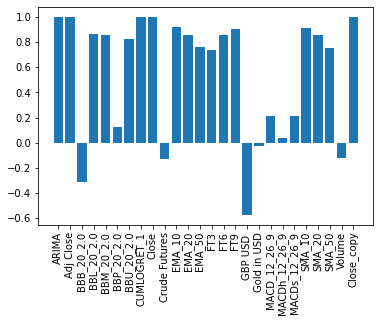

In [72]:
plt.bar(list(store_dict.keys()), list(store_dict.values()))
plt.xticks(rotation=90)
plt.show()

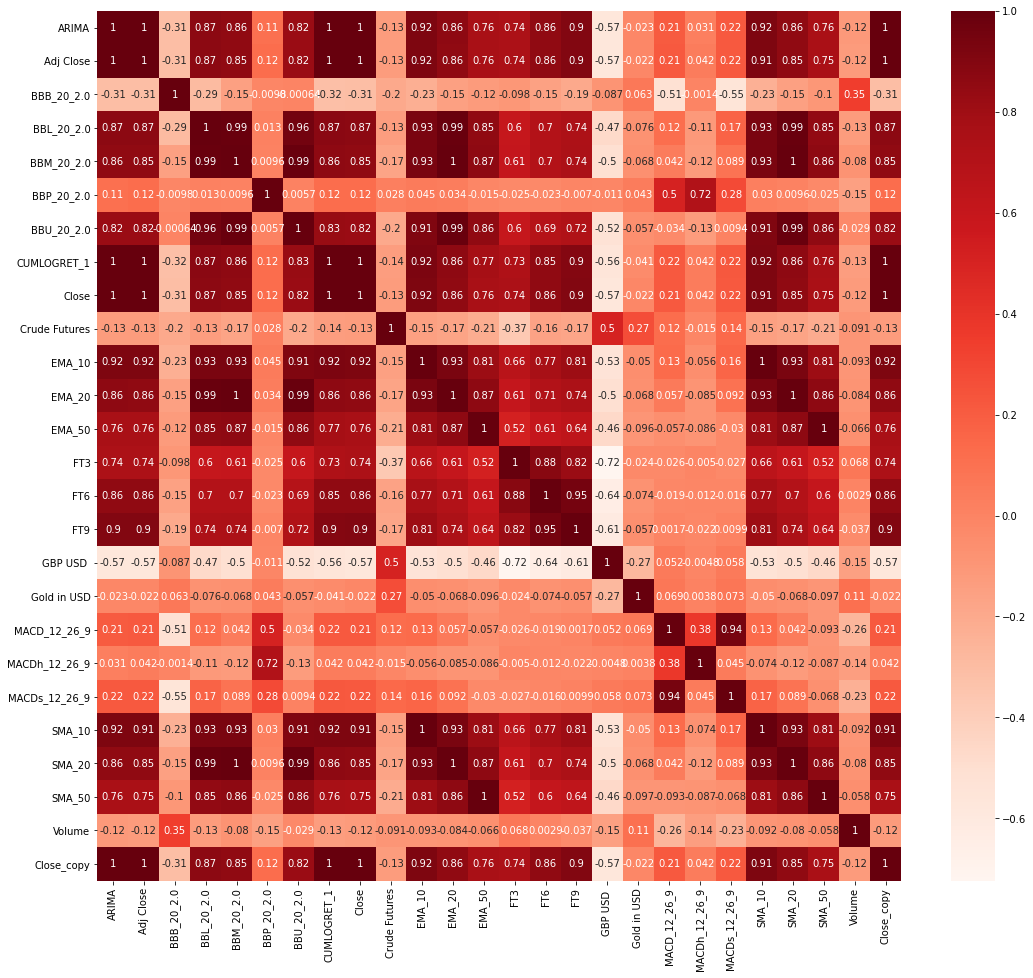

In [73]:
plt.figure(figsize=(18,16))
sns.heatmap(cormat, annot=True, cmap=plt.cm.Reds)
plt.show()

## Feature importance

In [74]:
df_feat_imp=dataset_total_df_clean.copy()
print(df_feat_imp.columns)

Index(['ARIMA', 'Adj Close', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0',
       'BBP_20_2.0', 'BBU_20_2.0', 'CUMLOGRET_1', 'Close', 'Crude Futures',
       'EMA_10', 'EMA_20', 'EMA_50', 'FT3', 'FT6', 'FT9', 'GBP USD ',
       'Gold in USD', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'SMA_10', 'SMA_20', 'SMA_50', 'Volume', 'Close_copy'],
      dtype='object')


In [75]:
for c in df_feat_imp.columns:
    mean = df_feat_imp[c].mean()
    stdev = df_feat_imp[c].std()
    df_feat_imp[c] = (df_feat_imp[c] - mean) / stdev

In [76]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
# define the model
model = XGBRegressor(objective ='reg:squarederror', 
                   seed = 123)
# fit the model
features_x=[i for i in features if i not in ['Adj Close','CUMLOGRET_1']]
X=df_feat_imp[features_x]
y=df_feat_imp['Close']
model.fit(X, y)
# get importance
importance = model.feature_importances_

In [77]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature:',features_x[i],'Score:',v)

Feature: ARIMA Score: 5.7084122e-05
Feature: BBB_20_2.0 Score: 1.0043496e-05
Feature: BBL_20_2.0 Score: 1.6242255e-05
Feature: BBM_20_2.0 Score: 3.1030657e-05
Feature: BBP_20_2.0 Score: 1.2654943e-05
Feature: BBU_20_2.0 Score: 2.2849179e-05
Feature: Close_copy Score: 0.99951756
Feature: Crude Futures Score: 1.7099741e-05
Feature: EMA_10 Score: 7.04584e-05
Feature: EMA_20 Score: 4.5799134e-05
Feature: EMA_50 Score: 1.07784945e-05
Feature: FT3 Score: 1.1573058e-05
Feature: FT6 Score: 1.5378895e-05
Feature: FT9 Score: 3.15946e-05
Feature: GBP USD  Score: 1.4637655e-05
Feature: Gold in USD Score: 9.933051e-06
Feature: MACD_12_26_9 Score: 1.1999947e-05
Feature: MACDh_12_26_9 Score: 1.6559568e-05
Feature: MACDs_12_26_9 Score: 1.3597028e-05
Feature: SMA_10 Score: 1.982771e-05
Feature: SMA_20 Score: 0.0
Feature: SMA_50 Score: 2.3394465e-05
Feature: Volume Score: 2.0057014e-05


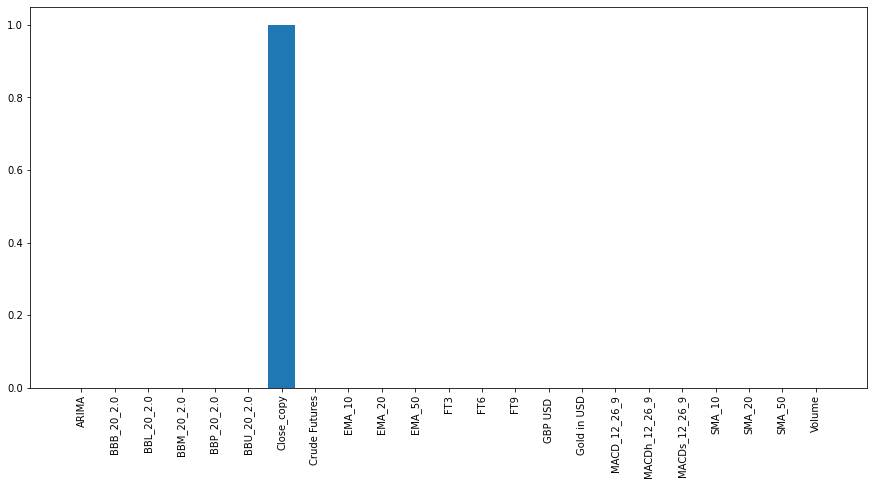

In [78]:
plt.figure(figsize=[15, 7])
# plot feature importance
plt.bar([x for x in features_x], importance)
plt.xticks(rotation=90)
plt.show()